# 0. Импорты и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

mpl.rcParams["figure.figsize"] = (9, 6)
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["savefig.dpi"] = 300

from src.data.load_events import load_raw_events, add_basic_time_cols

# Загружаем сырой датасет и добавляем базовые временные колонки
df = load_raw_events("data/raw/датасет_new.csv")
df = add_basic_time_cols(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269242 entries, 0 to 6269241
Data columns (total 14 columns):
 #   Column                            Dtype              
---  ------                            -----              
 0   Дата и время события              datetime64[ns, UTC]
 1   Экран                             object             
 2   Функционал                        object             
 3   Действие                          object             
 4   Идентификатор устройства          int64              
 5   Номер сессии в рамках устройства  int64              
 6   Производитель устройства          object             
 7   Модель устройства                 object             
 8   Тип устройства                    object             
 9   ОС                                object             
 10  date                              object             
 11  hour                              int32              
 12  weekday                           int32              
 1

In [2]:
# Проверка полных дубликатов строк (по исходным колонкам)
raw_cols = [
    'Дата и время события', 'Экран', 'Функционал', 'Действие',
    'Идентификатор устройства', 'Номер сессии в рамках устройства',
    'Производитель устройства', 'Модель устройства', 'Тип устройства', 'ОС'
]
raw_cols = [c for c in raw_cols if c in df.columns]

dup_mask = df.duplicated(subset=raw_cols, keep='first')
n_dup = int(dup_mask.sum())
print(f"Полных дубликатов строк: {n_dup:,} ({n_dup/len(df):.4%})")

if n_dup > 0:
    display(df.loc[dup_mask, raw_cols].head(10))


if n_dup > 0:
    df = df.drop_duplicates(subset=raw_cols, keep='first').reset_index(drop=True)
    print("После удаления дубликатов:", f"{len(df):,}")


Полных дубликатов строк: 2,908,592 (46.3946%)


,Дата и время события,Экран,Функционал,Действие,Идентификатор устройства,Номер сессии в рамках устройства,Производитель устройства,Модель устройства,Тип устройства,ОС
1,2025-09-29 07:20:27+00:00,Еще,Открытие экрана,NaN,339,10000000009,Redmi,Redmi Note 12,phone,Android
3,2025-09-29 07:21:56+00:00,Еще,Открытие экрана,NaN,339,10000000009,Redmi,Redmi Note 12,phone,Android
5,2025-09-29 07:22:01+00:00,Еще,Переход в раздел 'Заявки',Тап на кнопку 'Заявки',339,10000000009,Redmi,Redmi Note 12,phone,Android
7,2025-09-29 07:23:49+00:00,Еще,Открытие экрана,NaN,339,10000000009,Redmi,Redmi Note 12,phone,Android
9,2025-09-29 07:20:17+00:00,Новая заявка,Выбор квартиры,Тап на квартиру,339,10000000009,Redmi,Redmi Note 12,phone,Android
10,2025-09-29 07:20:17+00:00,Новая заявка,Выбор квартиры,Тап на квартиру,339,10000000009,Redmi,Redmi Note 12,phone,Android
11,2025-09-29 07:20:17+00:00,Новая заявка,Выбор квартиры,Тап на квартиру,339,10000000009,Redmi,Redmi Note 12,phone,Android
13,2025-09-29 07:20:23+00:00,Новая заявка,Выбор квартиры,Тап на квартиру,339,10000000009,Redmi,Redmi Note 12,phone,Android
14,2025-09-29 07:20:23+00:00,Новая заявка,Выбор квартиры,Тап на квартиру,339,10000000009,Redmi,Redmi Note 12,phone,Android
15,2025-09-29 07:20:23+00:00,Новая заявка,Выбор квартиры,Тап на квартиру,339,10000000009,Redmi,Redmi Note 12,phone,Android


После удаления дубликатов: 3,360,650


# 1. Категориальные признаки + пропуски

In [3]:
# Категориальные признаки
cat_cols = [
    'Экран', 'Функционал', 'Действие',
    'Производитель устройства', 'Модель устройства',
    'Тип устройства', 'ОС'
]

for col in cat_cols:
    df[col] = df[col].astype('category')

# Пропуски по всем колонкам
df.isna().mean().sort_values(ascending=False).head(10)


Действие                            0.525308
Дата и время события                0.000000
Экран                               0.000000
Функционал                          0.000000
Идентификатор устройства            0.000000
Номер сессии в рамках устройства    0.000000
Производитель устройства            0.000000
Модель устройства                   0.000000
Тип устройства                      0.000000
ОС                                  0.000000
dtype: float64

In [4]:
df['Действие'] = df['Действие'].cat.add_categories(['no_action'])
df['Действие'] = df['Действие'].fillna('no_action')


# 2. Базовые описательные статистики

In [5]:
print("Число событий:", len(df))
print("Уникальных устройств:", df['Идентификатор устройства'].nunique())
print("Уникальных сессий:", df[['Идентификатор устройства','Номер сессии в рамках устройства']].drop_duplicates().shape[0])
print("Диапазон дат:", df['Дата и время события'].min(), "→", df['Дата и время события'].max())

Число событий: 3360650
Уникальных устройств: 179976
Уникальных сессий: 1002265
Диапазон дат: 2025-08-31 21:00:05+00:00 → 2025-10-31 20:59:54+00:00


# 3. Временные паттерны

## 3.1. События по дням

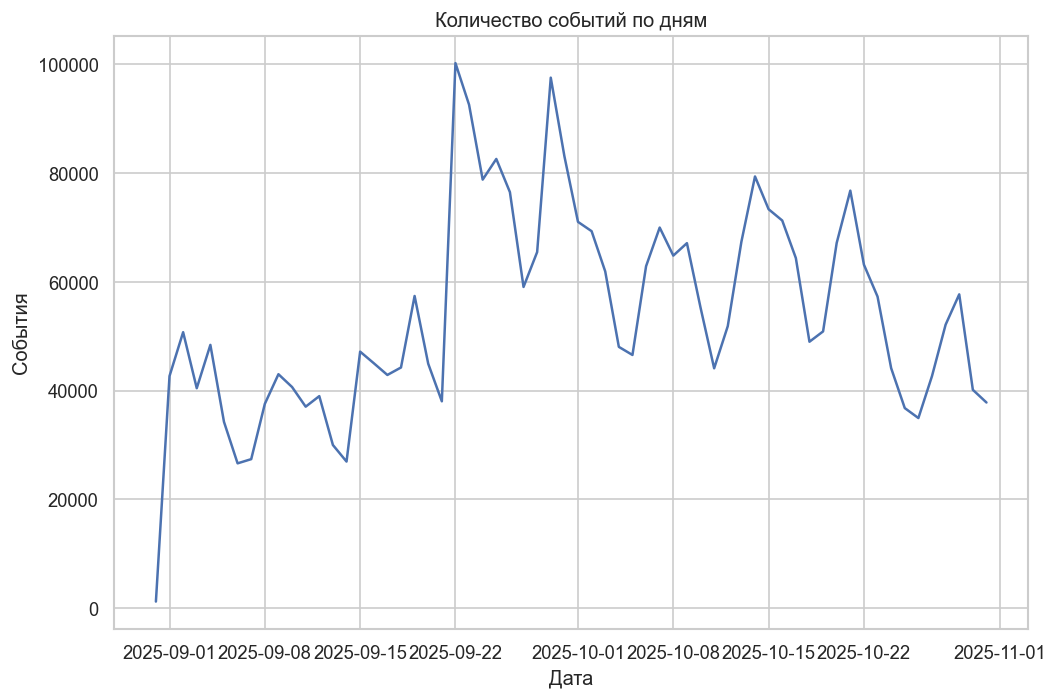

In [6]:
events_per_day = df.groupby('date').size()

events_per_day.plot()
plt.title("Количество событий по дням")
plt.ylabel("События")
plt.xlabel("Дата")

plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2. События по часам

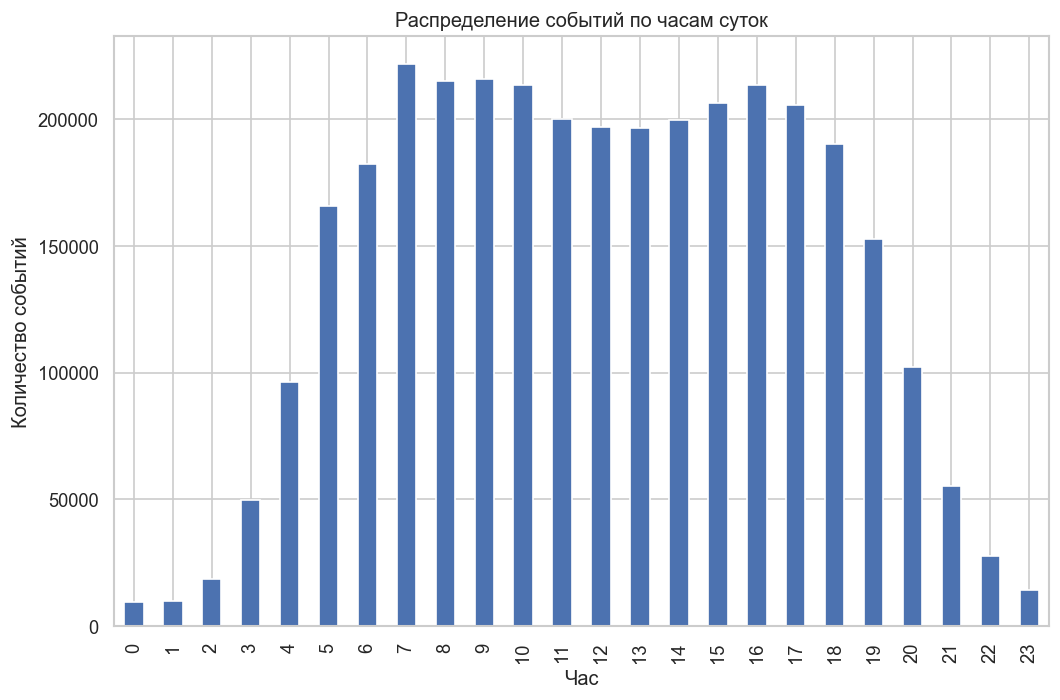

In [7]:
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Распределение событий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество событий")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. ОС, устройства, экраны

## 4.1. ОС

In [8]:
df['ОС'].value_counts(normalize=True) * 100

ОС
Android    57.692649
iOS        42.307351
Name: proportion, dtype: float64

## 4.2. Топ экранов

In [9]:
df['Экран'].value_counts().head(15)
df['Экран'].value_counts(normalize=True).head(15) * 100

Экран
Еще                          51.592132
Новая заявка                 24.906670
Заявки                        9.319269
Важное                        6.977043
Мой дом                       2.344308
Услуги                        1.499383
Мои баллы                     1.224793
Гостевой доступ               0.646839
Новое ОСС                     0.593308
Объявления                    0.562183
Связаться с владельцем ТС     0.224004
Новый адрес                   0.093940
Техподдержка                  0.016128
Name: proportion, dtype: float64

## 4.3. Тип устройства × ОС

In [10]:
pd.crosstab(df['ОС'], df['Тип устройства'], normalize='index') * 100

Тип устройства,phone,tablet
ОС,,
Android,98.785619,1.214381
iOS,99.337601,0.662399


## 4.4. Топ производителей и моделей

In [11]:
df['Производитель устройства'].value_counts().head(10)

Производитель устройства
Apple      1421802
Samsung     621359
Redmi       314671
Huawei      198365
Xiaomi      189513
POCO        135760
Realme      115724
Honor        86531
Tecno        59511
OnePlus      40813
Name: count, dtype: int64

In [12]:
df['Модель устройства'].value_counts().head(10)

Модель устройства
iPhone 11            119652
iPhone 15 Pro Max    109786
iPhone 16 Pro Max    106329
iPhone 13             97370
iPhone 14 Pro Max     86272
iPhone 15 Pro         79853
iPhone 16 Pro         79797
iPhone 13 Pro Max     73418
iPhone 14 Pro         68676
iPhone 13 Pro         63790
Name: count, dtype: int64

## 5. Дни недели + day×hour heatmap

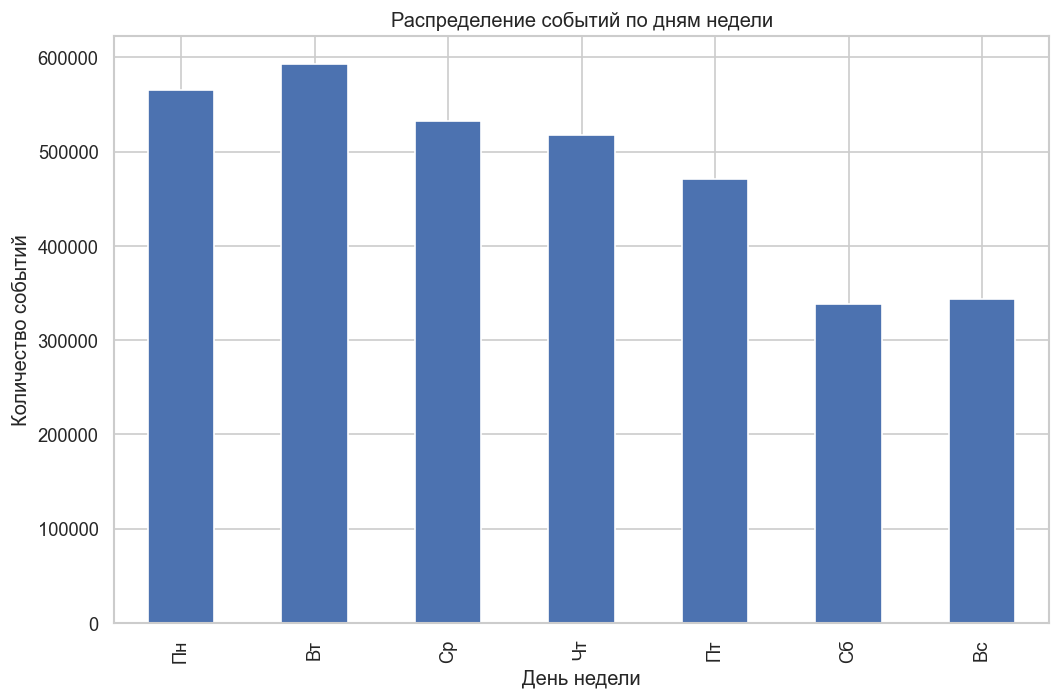

In [13]:
weekday_map = {
    0: "Пн", 1: "Вт", 2: "Ср",
    3: "Чт", 4: "Пт", 5: "Сб", 6: "Вс"
}

events_per_weekday = df['weekday'].map(weekday_map).value_counts().reindex(
    ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
)

events_per_weekday.plot(kind='bar')
plt.title("Распределение событий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество событий")
plt.tight_layout()
plt.show()

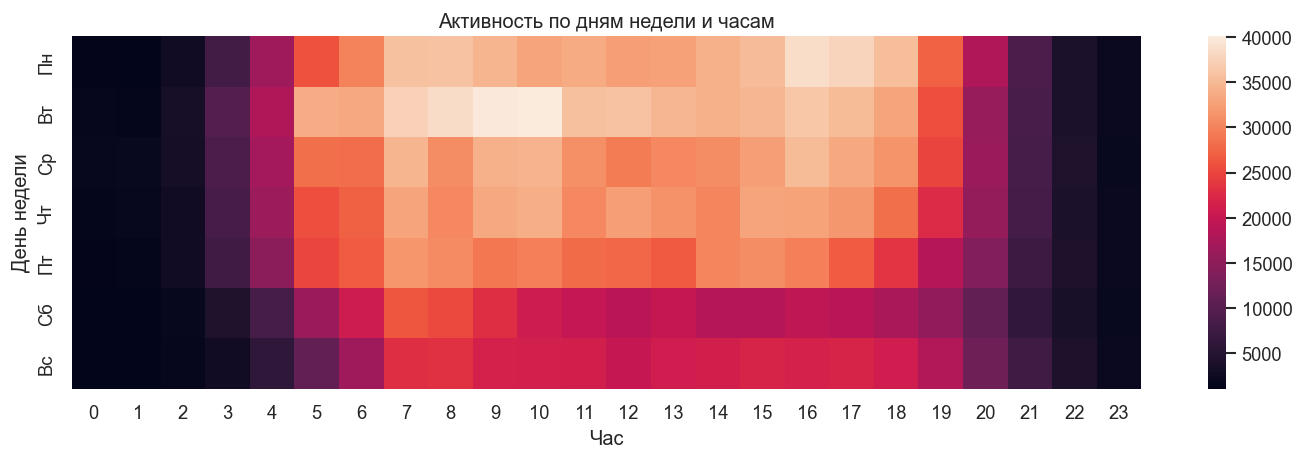

In [14]:
pivot = df.pivot_table(
    index='weekday',
    columns='hour',
    values='Идентификатор устройства',
    aggfunc='count',
    fill_value=0
)

pivot.index = pivot.index.map(weekday_map)

plt.figure(figsize=(12, 4))
sns.heatmap(pivot, annot=False)
plt.title("Активность по дням недели и часам")
plt.xlabel("Час")
plt.ylabel("День недели")
plt.tight_layout()
plt.show()

# 6. Функционал, действия

## 6.1. Функционал

In [15]:
func_counts = df['Функционал'].value_counts().head(15)
func_props = df['Функционал'].value_counts(normalize=True).head(15) * 100

func_table = pd.concat([func_counts, func_props], axis=1)
func_table.columns = ['count', 'proportion']
func_table

,count,proportion
Функционал,,
Открытие экрана,1759123,52.344725
Просмотр уведомления,234474,6.977043
Переход в раздел 'Заявки',200179,5.956556
Возврат на предыдущий этап,141793,4.219214
Выбор через теги,137334,4.086531
Переход в раздел 'Опросы и собрания собственников',126429,3.762040
Переход к просмотру заявки,87227,2.595540
Переход в раздел 'Приборы учета',65184,1.939625
Переход в раздел 'Мои платежи',58452,1.739306


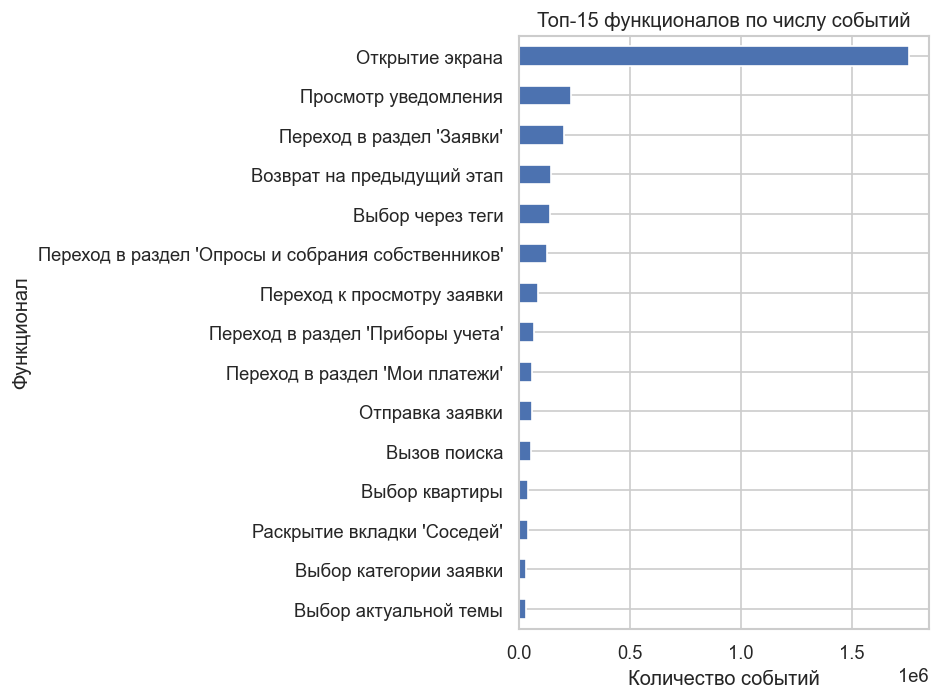

In [16]:
func_counts.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Топ-15 функционалов по числу событий")
plt.xlabel("Количество событий")
plt.tight_layout()
plt.show()

## 6.2. Экран × ОС

In [17]:
screen_os = pd.crosstab(df['Экран'], df['ОС'], normalize='columns') * 100
screen_os.head(10)


ОС,Android,iOS
Экран,,
Важное,7.050475,6.876907
Гостевой доступ,0.866958,0.346673
Еще,45.232478,60.264509
Заявки,10.012647,8.373740
Мои баллы,1.358487,1.042480
Мой дом,3.941000,0.166971
Новая заявка,28.338168,20.227289
Новое ОСС,0.520206,0.692994
Новый адрес,0.159012,0.005205


## 6.3. Действия

In [18]:
action_counts = df['Действие'].value_counts().head(20)
action_counts

Действие
no_action                                          1765376
Тап на уведомление                                  234474
Тап на кнопку 'Заявки'                              200179
Тап на стрелку назад                                141793
Тап на кнопку 'Опросы и собрания собственников'     126429
Тап на заявку                                        87227
Тап на кнопку 'Мои платежи'                          58452
выбор тега 1                                         57488
Тап на кнопку 'Создать заявку'                       56410
Тап на кнопку поиска                                 54895
Тап на кнопку 'Соседей'                              43188
Тап на кнопку 'Приборы учёта'                        42017
Тап на квартиру                                      41818
Тап на категорию                                     30159
Выбор тега 1                                         29507
Тап на кнопку 'Профиль'                              27338
Тап на объект                                  

## 7. Пользовательский уровень и черновой churn

In [22]:
user_agg = df.groupby('Идентификатор устройства').agg(
    events_total=('Дата и время события', 'size'),
    sessions_total=('Номер сессии в рамках устройства', 'nunique'),
    first_event=('Дата и время события', 'min'),
    last_event=('Дата и время события', 'max')
).reset_index()

user_agg['active_days'] = (user_agg['last_event'] - user_agg['first_event']).dt.days + 1

In [23]:
user_agg['events_total'].describe()
user_agg['sessions_total'].describe()
user_agg['active_days'].describe()

count    179976.00000
mean         17.26014
std          17.62591
min           1.00000
25%           1.00000
50%          11.00000
75%          31.00000
max          61.00000
Name: active_days, dtype: float64

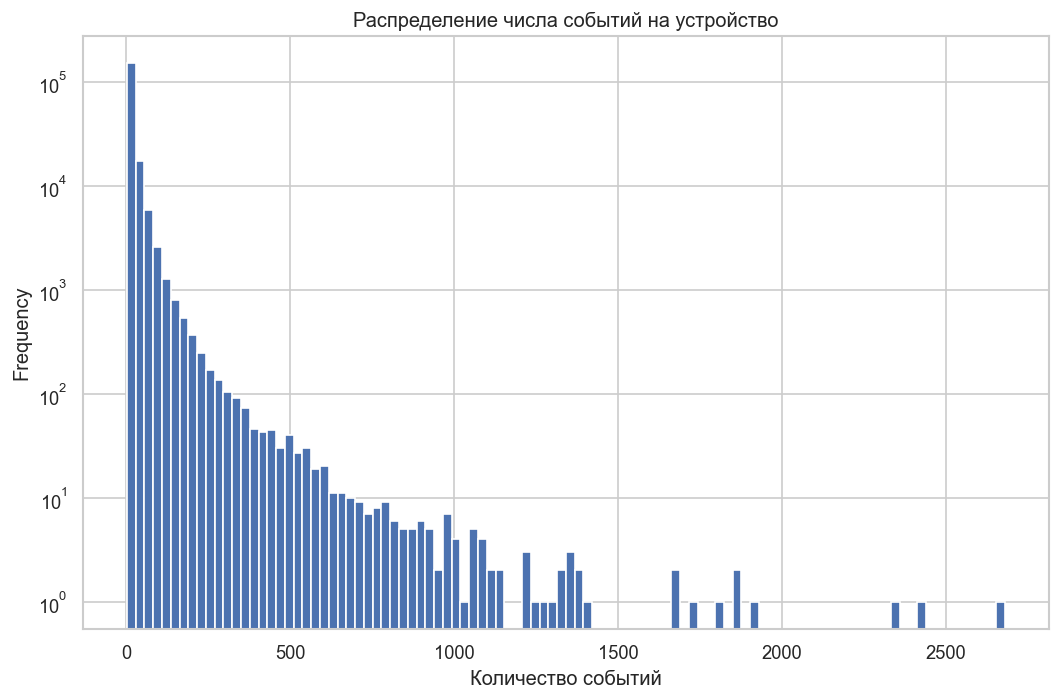

In [24]:
user_agg['events_total'].plot(kind='hist', bins=100, logy=True)
plt.title("Распределение числа событий на устройство")
plt.xlabel("Количество событий")
plt.tight_layout()
plt.grid(True)
plt.show()

## 7.1. Черновой churn_30d

In [45]:
max_date = df['Дата и время события'].max()

user_agg['recency_days'] = (max_date - user_agg['last_event']).dt.days
user_agg['churn_30d'] = (user_agg['recency_days'] > 30).astype(int)

(user_agg['churn_30d'].value_counts(normalize=True) * 100).round(2)

churn_30d
0    67.11
1    32.89
Name: proportion, dtype: float64

# 8. Сессии и дополнительные метрики

In [26]:
# Session-level: агрегация по (устройство × номер сессии)
session_agg = df.groupby(
    ['Идентификатор устройства', 'Номер сессии в рамках устройства'],
    sort=False,
    observed=True
).agg(
    events_in_session=('Дата и время события', 'size'),
    session_start=('Дата и время события', 'min'),
    session_end=('Дата и время события', 'max')
).reset_index()

session_agg['session_duration_sec'] = (session_agg['session_end'] - session_agg['session_start']).dt.total_seconds()
session_agg['is_single_event_session'] = (session_agg['events_in_session'] == 1).astype(int)

session_agg[['events_in_session','session_duration_sec']].describe()

,events_in_session,session_duration_sec
count,1.002265e+06,1.002265e+06
mean,3.353055e+00,8.186507e+02
std,4.615518e+00,4.180398e+04
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00
50%,2.000000e+00,3.000000e+00
75%,4.000000e+00,3.600000e+01
max,2.200000e+02,4.319589e+06


## 8.1. Сравнение метрик по churn

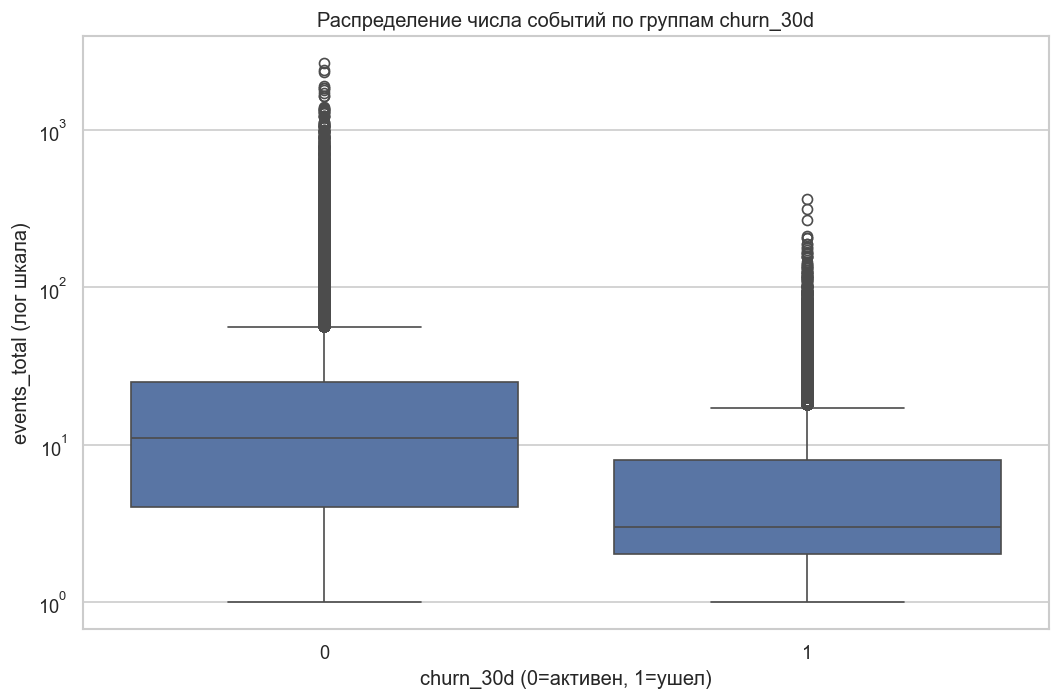

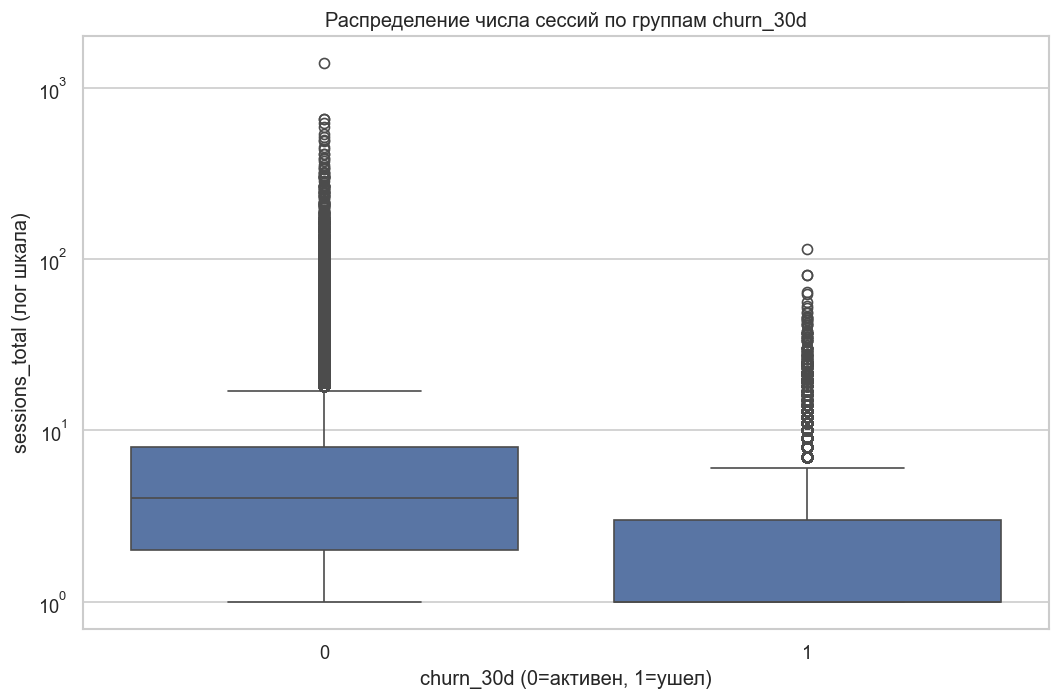

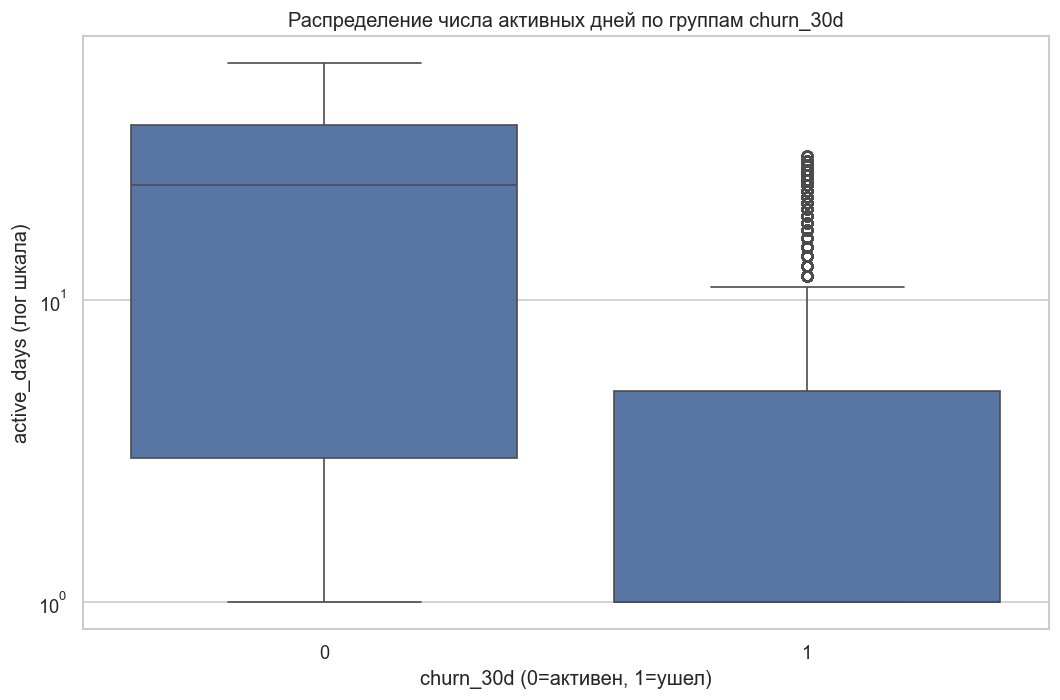

In [27]:
sns.boxplot(data=user_agg, x='churn_30d', y='events_total')
plt.yscale('log')
plt.title("Распределение числа событий по группам churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("events_total (лог шкала)")
plt.tight_layout()
plt.show()

sns.boxplot(data=user_agg, x='churn_30d', y='sessions_total')
plt.yscale('log')
plt.title("Распределение числа сессий по группам churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("sessions_total (лог шкала)")
plt.tight_layout()
plt.show()

sns.boxplot(data=user_agg, x='churn_30d', y='active_days')
plt.yscale('log')
plt.title("Распределение числа активных дней по группам churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("active_days (лог шкала)")
plt.tight_layout()
plt.show()


## 8.2. ОС × churn

In [46]:
user_os = df.groupby('Идентификатор устройства')['ОС'].agg(lambda x: x.mode()[0]).reset_index()
user_agg_os = user_agg.merge(user_os, on='Идентификатор устройства', how='left')

(pd.crosstab(user_agg_os['ОС'], user_agg_os['churn_30d'], normalize='index') * 100).round(2)

churn_30d,0,1
ОС,,
Android,71.19,28.81
iOS,63.85,36.15


In [33]:
# Last screen: где заканчивают (последнее событие пользователя)
# last_screen = экран последнего события в окне наблюдения
last_idx = df.groupby('Идентификатор устройства')['Дата и время события'].idxmax()
last_events = df.loc[last_idx, ['Идентификатор устройства', 'Экран', 'Дата и время события']].copy()
last_events = last_events.rename(columns={'Экран': 'last_screen', 'Дата и время события': 'last_ts'})

# last_non_more_screen = последний экран, кроме "Еще" (чтобы убрать доминирование хаба)
df_nm = df[df['Экран'] != 'Еще'].copy()
last_idx_nm = df_nm.groupby('Идентификатор устройства')['Дата и время события'].idxmax()
last_events_nm = df_nm.loc[last_idx_nm, ['Идентификатор устройства', 'Экран']].rename(columns={'Экран':'last_non_more_screen'})

# os на пользователя
user_os2 = user_os.rename(columns={'ОС':'os'})

last_events = (
    last_events
    .merge(user_os2, on='Идентификатор устройства', how='left')
    .merge(user_agg[['Идентификатор устройства','churn_30d']], on='Идентификатор устройства', how='left')
    .merge(last_events_nm, on='Идентификатор устройства', how='left')
)

#last_events['last_non_more_screen'] = last_events['last_non_more_screen'].fillna('only_Еще')

last_events.head()

,Идентификатор устройства,last_screen,last_ts,os,churn_30d,last_non_more_screen
0,1,Еще,2025-10-30 18:50:59+00:00,Android,0,Заявки
1,2,Еще,2025-10-20 08:47:36+00:00,Android,0,Новая заявка
2,3,Еще,2025-10-20 10:34:50+00:00,Android,0,Важное
3,4,Новая заявка,2025-10-25 21:28:28+00:00,Android,0,Новая заявка
4,5,Еще,2025-10-23 02:52:28+00:00,Android,0,NaN


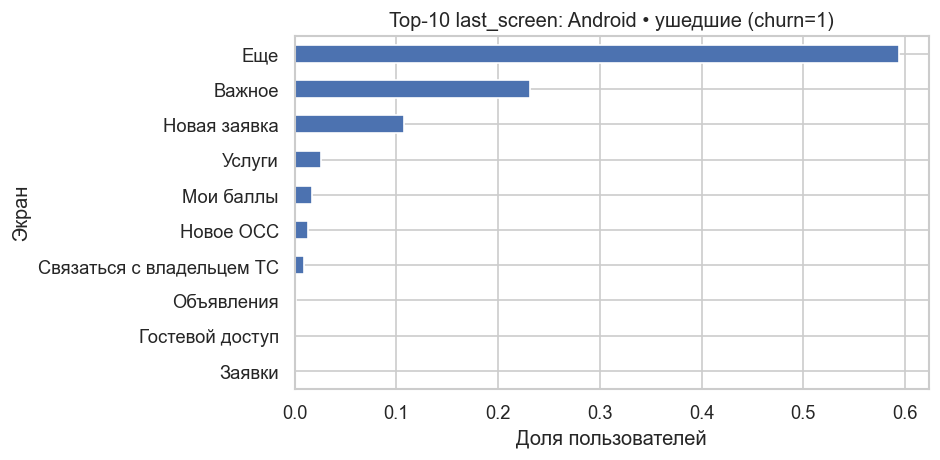

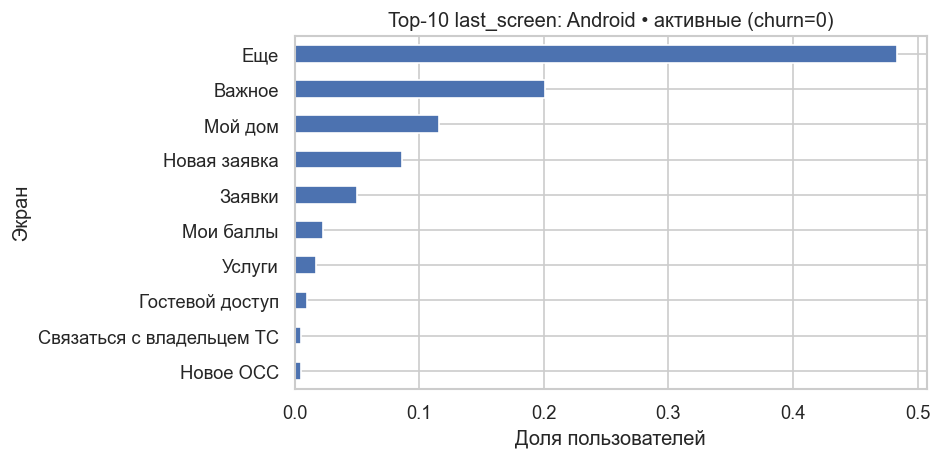

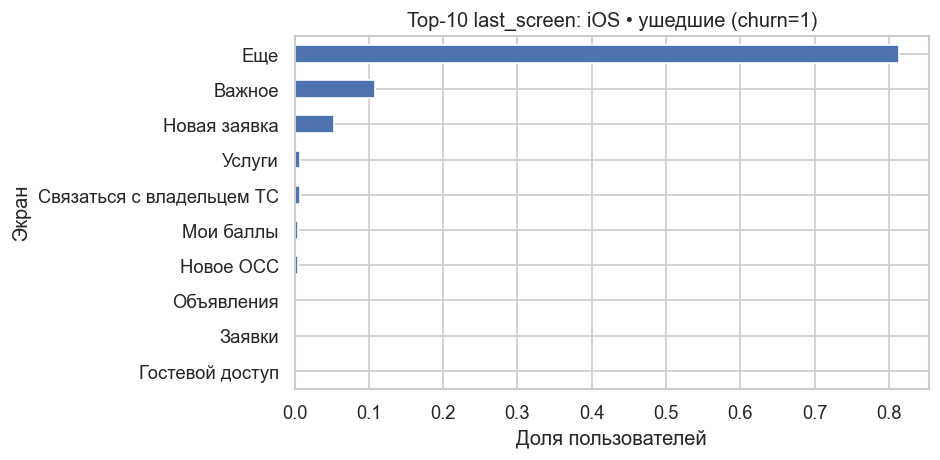

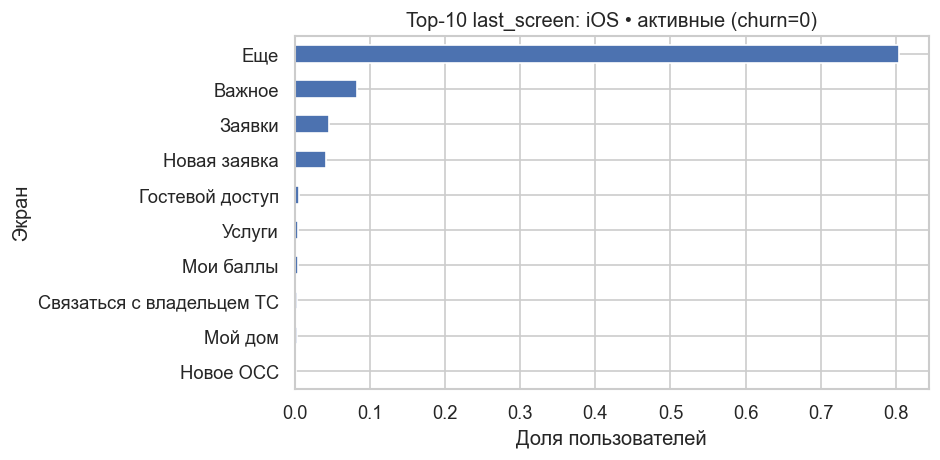

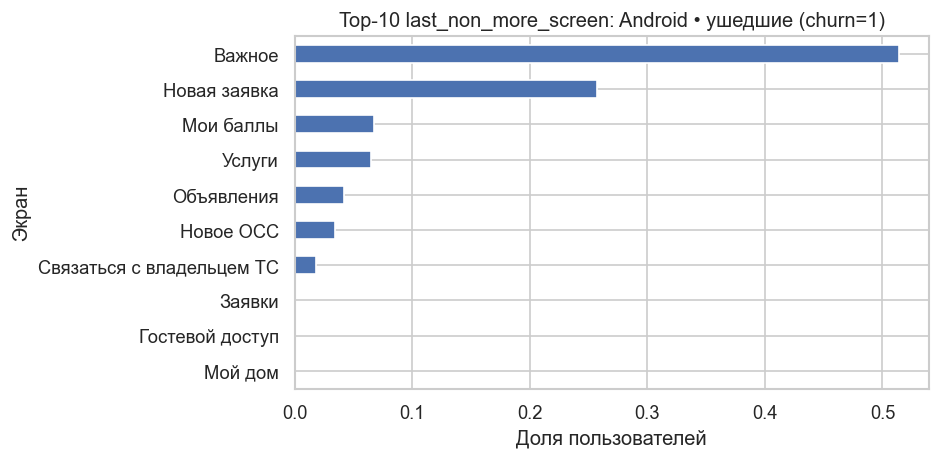

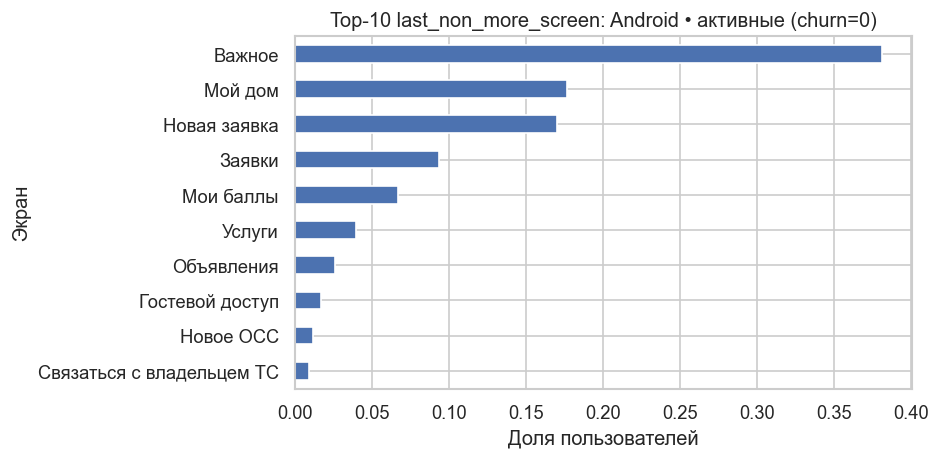

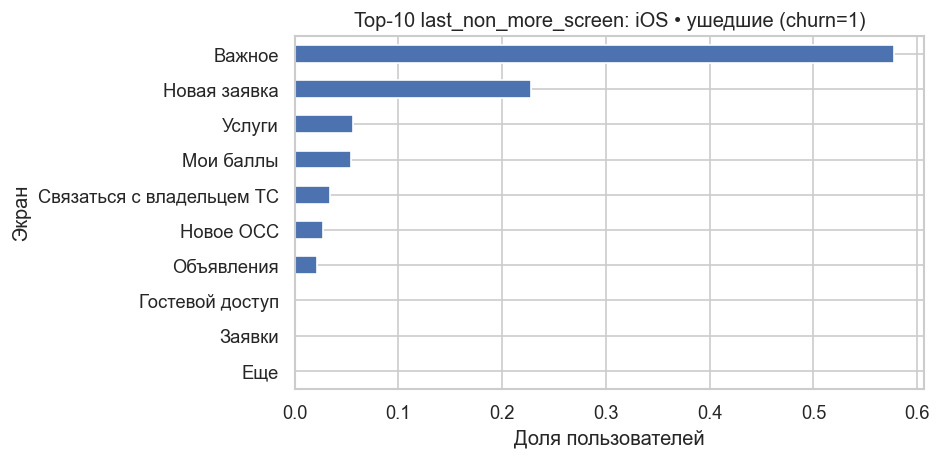

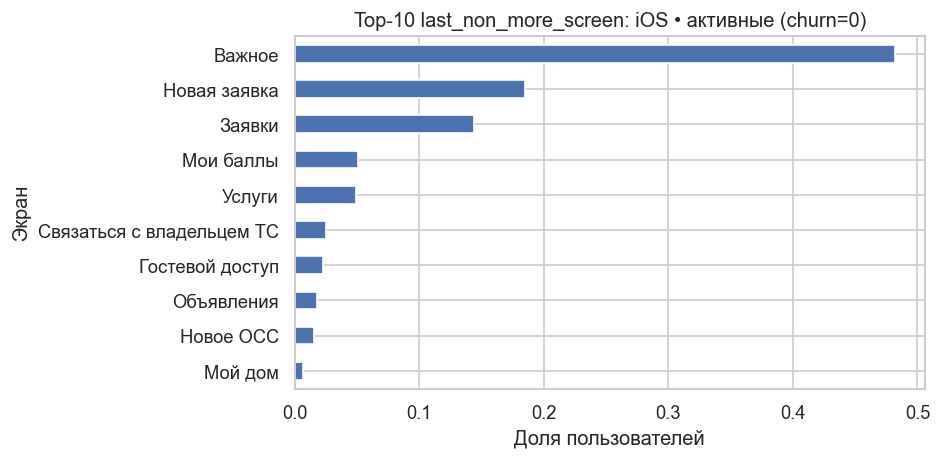

In [34]:
def plot_top_last(df_last, col_name, os_name, churn_value, top_n=10):
    status = "ушедшие (churn=1)" if churn_value == 1 else "активные (churn=0)"
    tmp = df_last[(df_last['os'] == os_name) & (df_last['churn_30d'] == churn_value)]
    vc = (tmp[col_name].value_counts(normalize=True).head(top_n).sort_values())

    plt.figure(figsize=(8,4))
    vc.plot(kind='barh')
    plt.title(f"Top-{top_n} {col_name}: {os_name} • {status}")
    plt.xlabel("Доля пользователей")
    plt.ylabel("Экран")
    plt.tight_layout()
    plt.show()

for os_name in ['Android','iOS']:
    plot_top_last(last_events, 'last_screen', os_name, 1, top_n=10)
    plot_top_last(last_events, 'last_screen', os_name, 0, top_n=10)

# (опционально) то же самое, но без "Еще"
for os_name in ['Android','iOS']:
    plot_top_last(last_events, 'last_non_more_screen', os_name, 1, top_n=10)
    plot_top_last(last_events, 'last_non_more_screen', os_name, 0, top_n=10)


## 8.3. Разнообразие экранов

In [ ]:
user_screens = df.groupby('Идентификатор устройства')['Экран'].nunique().reset_index(name='unique_screens')
user_agg = user_agg.merge(user_screens, on='Идентификатор устройства', how='left')

user_agg['unique_screens'].describe()

sns.boxplot(data=user_agg, x='churn_30d', y='unique_screens')
plt.title("Сколько разных экранов используют ушедшие vs активные")
plt.tight_layout()
plt.show()

KeyError: 'unique_screens'

## 8.4. Средняя длина сессий на пользователя

In [37]:
# User-level: фичи по сессиям
def p90(x):
    return np.percentile(x, 90)

session_by_user = session_agg.groupby(
    'Идентификатор устройства',
    observed=True
).agg(
    mean_session_events=('events_in_session', 'mean'),
    median_session_events=('events_in_session', 'median'),
    mean_session_duration=('session_duration_sec', 'mean'),
    median_session_duration=('session_duration_sec', 'median'),
    p90_session_duration=('session_duration_sec', p90),
    share_single_event_sessions=('is_single_event_session', 'mean')
).reset_index()

user_agg = user_agg.merge(session_by_user, on='Идентификатор устройства', how='left')
user_agg.head()

,Идентификатор устройства,events_total,sessions_total,first_event,last_event,active_days,recency_days,churn_30d,unique_screens_x,mean_session_events_x,...,share_single_event_sessions_x,mean_session_duration_log,unique_screens_y,Экран,mean_session_events_y,median_session_events_y,mean_session_duration_y,median_session_duration_y,p90_session_duration_y,share_single_event_sessions_y
0,1,469,70,2025-09-01 08:31:05+00:00,2025-10-30 18:50:59+00:00,60,1,0,6,6.700000,...,0.000000,4.000819,6,6,6.700000,5.0,53.642857,37.0,118.1,0.000000
1,2,122,44,2025-09-19 17:38:56+00:00,2025-10-20 08:47:36+00:00,31,11,0,5,2.772727,...,0.681818,2.680399,5,5,2.772727,1.0,13.590909,0.0,35.1,0.681818
2,3,20,3,2025-10-09 09:20:36+00:00,2025-10-20 10:34:50+00:00,12,11,0,2,6.666667,...,0.000000,4.867534,2,2,6.666667,6.0,129.000000,96.0,244.8,0.000000
3,4,71,10,2025-10-04 10:08:08+00:00,2025-10-25 21:28:28+00:00,22,5,0,5,7.100000,...,0.100000,4.320151,5,5,7.100000,4.0,74.200000,31.5,220.1,0.100000
4,5,3,2,2025-10-20 09:41:02+00:00,2025-10-23 02:52:28+00:00,3,8,0,1,1.500000,...,0.500000,0.916291,1,1,1.500000,1.5,1.500000,1.5,2.7,0.500000


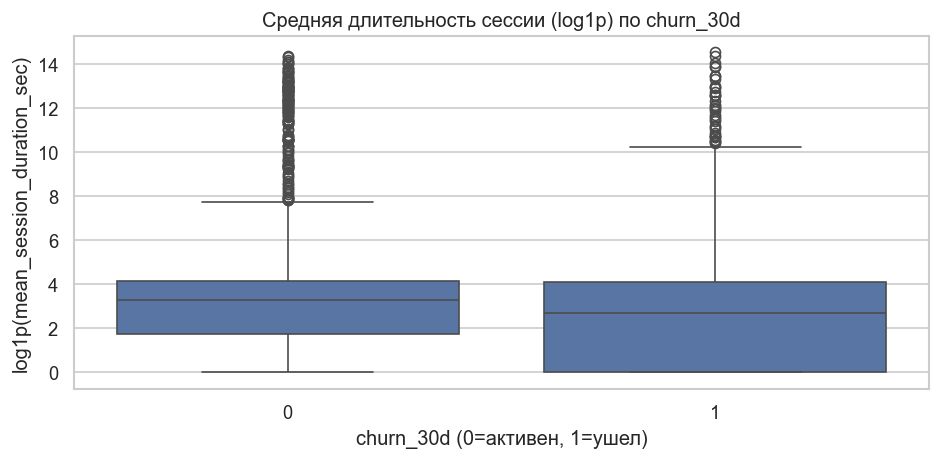

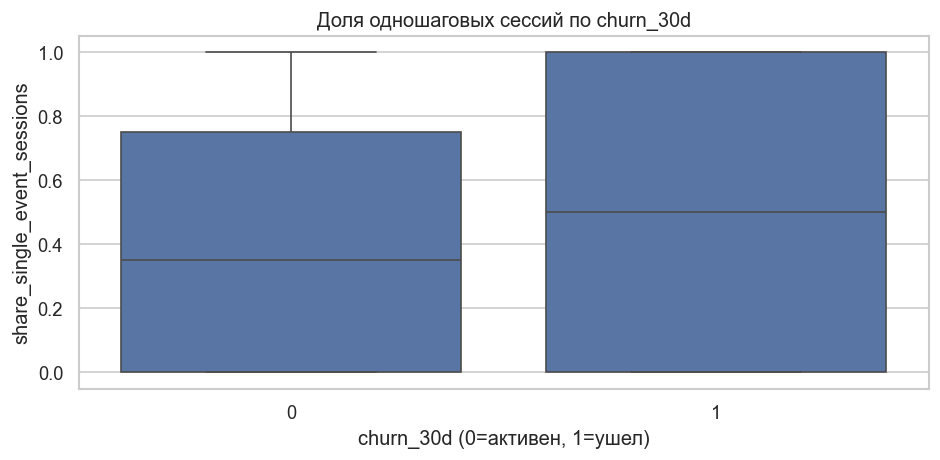

In [31]:
# Session duration / single-event sessions vs churn
user_agg['mean_session_duration_log'] = np.log1p(user_agg['mean_session_duration'])

plt.figure(figsize=(8,4))
sns.boxplot(data=user_agg, x='churn_30d', y='mean_session_duration_log')
plt.title("Средняя длительность сессии (log1p) по churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("log1p(mean_session_duration_sec)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=user_agg, x='churn_30d', y='share_single_event_sessions')
plt.title("Доля одношаговых сессий по churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("share_single_event_sessions")
plt.tight_layout()
plt.show()

## 9. Дополнительные гистограммы и boxplot’ы

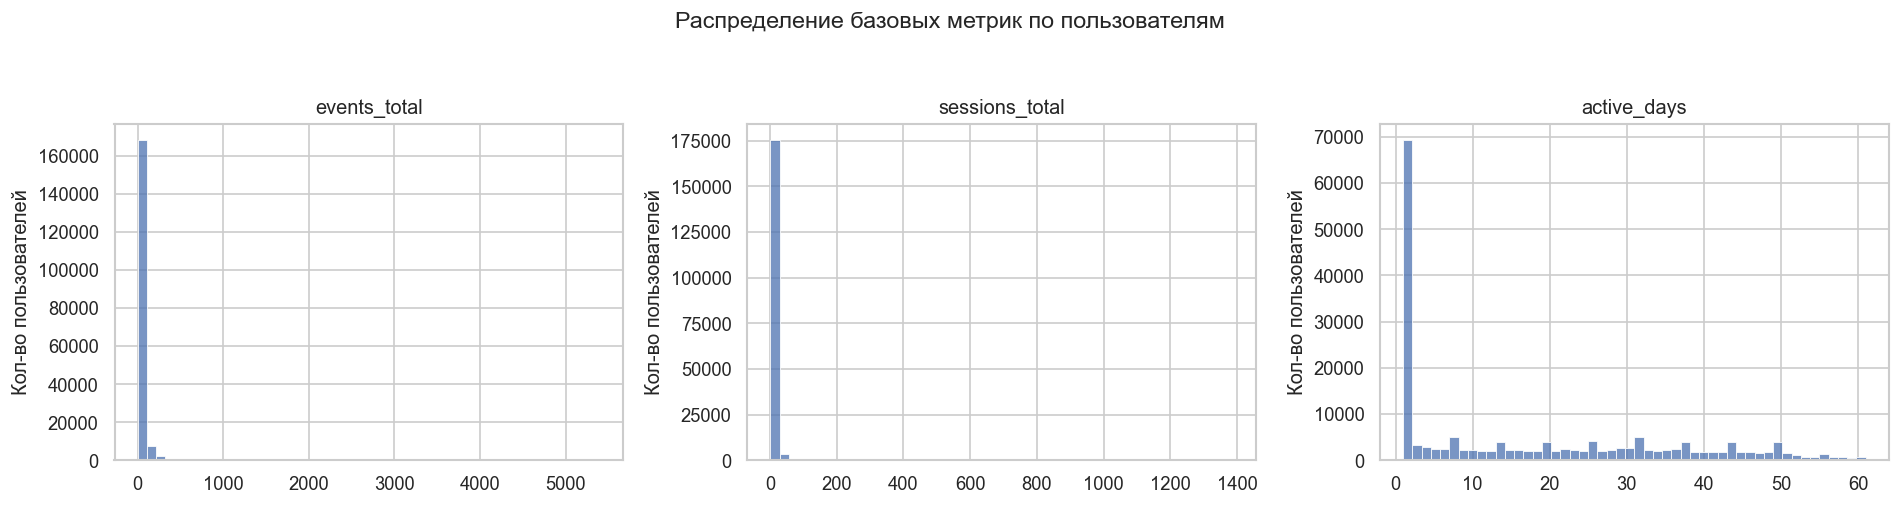

In [35]:
metrics = ['events_total', 'sessions_total', 'active_days']

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4))

for ax, col in zip(axes, metrics):
    sns.histplot(user_agg[col], bins=50, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Кол-во пользователей')

plt.suptitle("Распределение базовых метрик по пользователям", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

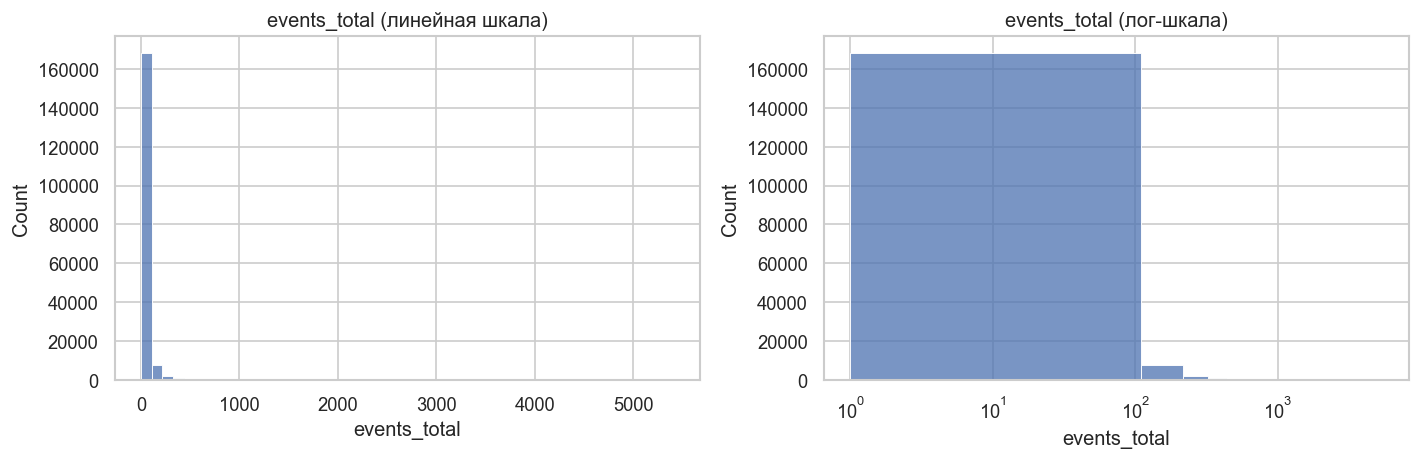

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(user_agg['events_total'], bins=50, ax=axes[0])
axes[0].set_title("events_total (линейная шкала)")

sns.histplot(user_agg['events_total'], bins=50, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_title("events_total (лог-шкала)")

plt.tight_layout()
plt.show()

# 10. Customer journey

C:\Users\User\AppData\Local\Temp\ipykernel_25932\304446346.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transitions_count = transitions.groupby(['prev_screen', 'Экран']).size().reset_index(name='count')


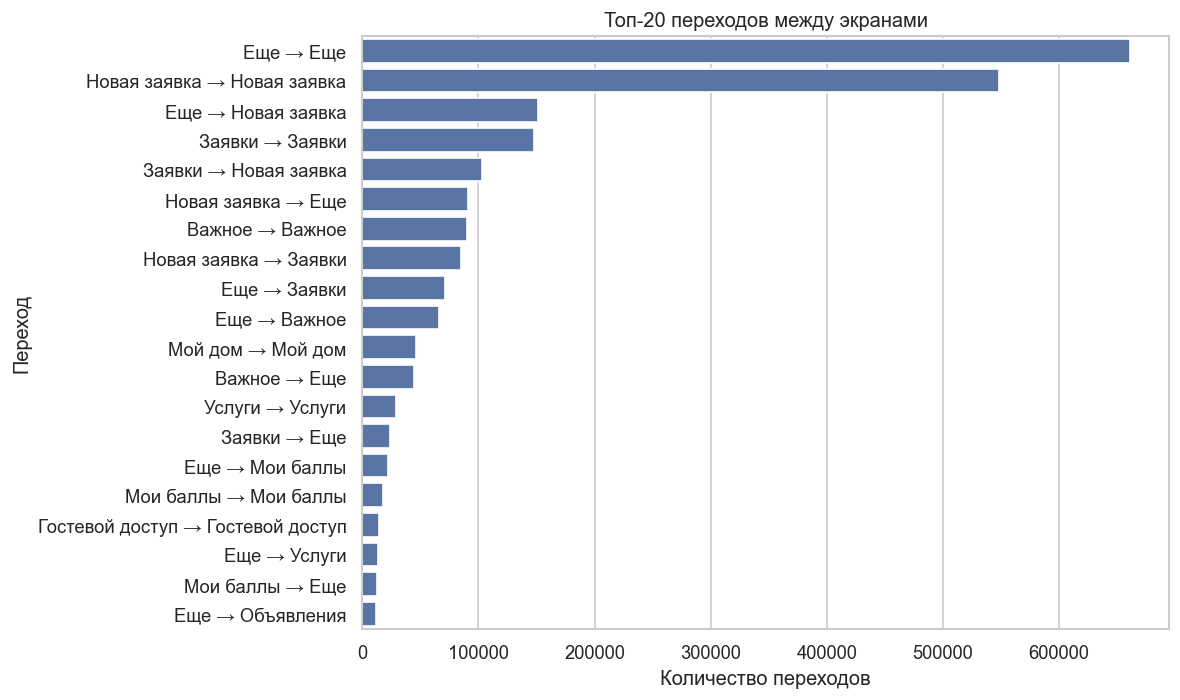

In [38]:
df_sorted = df.sort_values(
    ['Идентификатор устройства', 'Номер сессии в рамках устройства', 'Дата и время события']
)

df_sorted['prev_screen'] = df_sorted.groupby(
    ['Идентификатор устройства', 'Номер сессии в рамках устройства']
)['Экран'].shift(1)

transitions = df_sorted.dropna(subset=['prev_screen'])

transitions_count = transitions.groupby(['prev_screen', 'Экран']).size().reset_index(name='count')

top_n = 20
top_transitions = (
    transitions_count
    .sort_values('count', ascending=False)
    .head(top_n)
    .copy()
)

top_transitions['transition'] = (
    top_transitions['prev_screen'].astype(str)
    + ' → '
    + top_transitions['Экран'].astype(str)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_transitions,
    x='count',
    y='transition'
)
plt.title(f"Топ-{top_n} переходов между экранами")
plt.xlabel("Количество переходов")
plt.ylabel("Переход")
plt.tight_layout()
plt.show()

In [43]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.colors import qualitative

os.makedirs("reports/figures", exist_ok=True)

def to_rgba(color, alpha=0.30):
    # plotly palettes часто в формате "rgb(r,g,b)"
    if isinstance(color, str) and color.startswith("rgb("):
        rgb = color[4:-1]  # "r,g,b"
        return f"rgba({rgb},{alpha})"
    # или hex "#RRGGBB"
    if isinstance(color, str) and color.startswith("#") and len(color) == 7:
        h = color.lstrip('#')
        r, g, b = int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16)
        return f"rgba({r},{g},{b},{alpha})"
    return color

def norm_screen(s: object) -> object:
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    # нормализуем частый кейс "Ещё" vs "Еще"
    s = s.replace("Ещё", "Еще").replace("ещё", "еще")
    return s

def build_sankey(transitions_count, screens, top_k_per_source=3, normalize=True,
                title="Customer journey (Sankey)"):
    tc = transitions_count.copy()

    # ВАЖНО: приводим к нормализованным строкам
    tc['prev_screen'] = tc['prev_screen'].map(norm_screen)
    tc['Экран'] = tc['Экран'].map(norm_screen)

    # фильтр по нужным экранам
    tc = tc[
        tc['prev_screen'].isin(screens) &
        tc['Экран'].isin(screens)
    ].copy()

    # убираем self-loops (типа "Еще → Еще")
    tc = tc[tc['prev_screen'] != tc['Экран']].copy()

    if tc.empty:
        raise ValueError("После фильтрации transitions_count пустой. Проверь screens и значения в данных.")

    # нормируем внутри источника (чтобы 'Еще' не доминировал объёмом)
    if normalize:
        tc['value'] = tc.groupby('prev_screen')['count'].transform(lambda x: x / x.sum())
        tc['value'] = tc['value'] * 100
    else:
        tc['value'] = tc['count'].astype(float)

    # оставляем top-K переходов на каждый source
    tc = tc.sort_values(['prev_screen', 'value'], ascending=[True, False])
    tc = tc.groupby('prev_screen', as_index=False).head(top_k_per_source)

    # порядок узлов — как в screens
    nodes = list(screens)
    node_index = {n: i for i, n in enumerate(nodes)}

    # маппинг в индексы
    src = tc['prev_screen'].map(node_index)
    tgt = tc['Экран'].map(node_index)

    # если вдруг что-то не смэпилось
    bad = src.isna() | tgt.isna()
    if bad.any():
        bad_rows = tc.loc[bad, ['prev_screen', 'Экран', 'count']].head(20)
        print("Есть переходы с экранами вне nodes, они будут удалены. Примеры:")
        display(bad_rows)

        tc = tc.loc[~bad].copy()
        src = src.loc[~bad]
        tgt = tgt.loc[~bad]

    source = src.astype(int).tolist()
    target = tgt.astype(int).tolist()
    value = tc['value'].astype(float).tolist()

    palette = qualitative.Set2
    color_map = {n: palette[i % len(palette)] for i, n in enumerate(nodes)}
    node_colors = [color_map[n] for n in nodes]
    link_colors = [to_rgba(color_map[nodes[i]], 0.25) for i in source]

    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            label=nodes,
            pad=5,
            thickness=18,
            color=node_colors,
            line=dict(color="rgba(255,255,255,0.7)", width=1)
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors,
            hovertemplate="Переход: %{source.label} → %{target.label}<br>Вес: %{value:.2f}<extra></extra>"
        )
    )])

    fig.update_layout(title=title, font_size=13, width=1100, height=520)
    return fig

key_screens = ['Еще', 'Новая заявка', 'Заявки', 'Мой дом', 'Мои платежи', 'Услуги', 'Важное']

fig = build_sankey(
    transitions_count,
    screens=key_screens,
    top_k_per_source=3,
    normalize=True,
    title="Customer journey: вероятности переходов (top-3 на источник, без self-loops)"
)

fig.write_html("reports/figures/customer_journey_sankey.html", include_plotlyjs="cdn")
fig

C:\Users\User\AppData\Local\Temp\ipykernel_25932\422831344.py:51: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_25932\422831344.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



1. Что уже можно писать в отчёт (интерпретация графиков)


Временные паттерны

По дням недели
Активность выше в будни, максимум — во вторник, затем понедельник/среда, к пятнице события постепенно снижаются.
В выходные (суббота–воскресенье) объём событий примерно на 30–40% ниже, чем в пиковые будние дни.

По часам и day×hour heatmap

Ночью (0–4 часа) активности почти нет.

С 5–6 утра начинается рост, первый пик приходится на 8–11 часов.

Днём активность сохраняется на высоком уровне, второй локальный пик — 16–18 часов, после 20 часов идёт спад.

В будни утренний и дневной пик выражены сильнее; в выходные активность более “размазана”, но в целом ниже.

Можно сформулировать:

Пользователи в основном взаимодействуют с приложением в рабочие дни и рабочее время, что ожидаемо для ЖКХ-сервисов (оплата, заявки и т.п.).



Устройства и ОС

ОС: ~62% событий приходится на Android и ~38% — на iOS.

Производители: в топе явно доминирует Apple, затем Samsung, дальше — китайские бренды (Redmi, Huawei, Xiaomi, POCO и др.).

Модели: топ‑10 моделей целиком заняты iPhone (11, 13, 14, 15, 16 и их Pro/Pro Max), то есть:

iOS‑устройства дают меньше уникальных девайсов, но больше событий на популярные модели;

Android‑устройства распределены по большему числу моделей.

Это можно сформулировать как:

Пользовательская база заметно смешанная (Android ~62%, iOS ~38%), при этом на iPhone приходится значительная доля трафика, сконцентрированная на нескольких популярных моделях.

Экраны, функционал, действия

Экраны (Экран)
В топе:

“Еще” — ~50% всех событий (главный “хаб” навигации, по сути меню).

“Новая заявка” — ~26%.

“Заявки” — ~9%.
Остальные экраны (важное, мой дом, услуги, баллы, гостевой доступ и т.п.) дают существенно меньшие доли.

По ОС и экранам
Интересный перекос:

Доля событий на экране “Еще”: ~44.5% на Android и ~60% на iOS.

“Новая заявка”: ~29% Android vs ~20% iOS.

“Мой дом”: заметная доля на Android (~3.9%), почти нулевая на iOS (~0.17%).
→ Можно сделать гипотезу: либо функционал “Мой дом” менее востребован/заметен на iOS, либо интерфейс/релиз отличается.

Функционал (Функционал)

“Открытие экрана” — ~52% событий → навигационные действия, лог событий UI.

“Просмотр уведомления” — ~7%.

“Переход в раздел 'Заявки'” — ~5.8%.

“Возврат на предыдущий этап”, “Выбор через теги”, “Переход в раздел 'ОСС'” и т.д. — по долям ниже, но показывают частые сценарии.

Действия (Действие)
Среди конкретных действий (без NaN):

“Тап на уведомление”, “Тап на кнопку 'Заявки'”, “Тап на стрелку назад”, “Тап на кнопку 'Опросы и собрания собственников'”, “Тап на заявку”, “Тап на кнопку 'Создать заявку'” — самые популярные.
Это подтверждает, что заявки и уведомления — ключевые сценарии.

Пользовательский уровень (device level)

По агрегации user_agg:

События на устройство (events_total):

медиана ~12 событий за весь период (2 месяца),

25-й перцентиль — 4, 75-й — 34,

максимум — 5402 (сильный хвост “суперактивных” пользователей).

Сессии на устройство (sessions_total):

медиана — 3 сессии,

75-й перцентиль — 6,

максимум — 1388 сессий.

Активные дни (active_days = last-first+1):

медиана — 11 дней,

25% пользователей активны только 1 день,

75% — активны до 31 дня, максимум 61 (весь период).

Можно описать:

Большая часть пользователей взаимодействует с приложением эпизодически (медиана ~12 событий, 3 сессии, 11 активных дней за два месяца). При этом существует небольшой пул суперактивных устройств, генерирующих сотни и тысячи событий

ушедшие пользователи имеют меньше событий/сессий/активных дней;

активные пользователи чаще используют приложение на протяжении всего периода.

Гипотеза: чем более разнообразно человек использует приложение (не только “Ещё” и “Новая заявка”), тем выше удержание. 
Отличие на 8%, iOS уходят чаще

### 3.2. Топ переходов для ушедших vs активных

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 20

top_churn = (
    transitions_churn_count
    .query("churn_30d == 1")
    .sort_values('count', ascending=False)
    .head(top_n)
    .copy()
)

top_active = (
    transitions_churn_count
    .query("churn_30d == 0")
    .sort_values('count', ascending=False)
    .head(top_n)
    .copy()
)

def plot_top_transitions(df_top, title):
    df_plot = df_top.copy()
    
    # prev_screen и Экран у нас category → приводим к str
    df_plot['transition'] = (
        df_plot['prev_screen'].astype(str)
        + ' → '
        + df_plot['Экран'].astype(str)
    )
    
    # чтобы самые большие были сверху
    df_plot = df_plot.sort_values('count', ascending=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot,
        x='count',
        y='transition'
    )
    plt.title(title)
    plt.xlabel("Количество переходов")
    plt.ylabel("Переход")
    plt.tight_layout()
    plt.show()

plot_top_transitions(top_active, "Топ переходов (активные пользователи)")
plot_top_transitions(top_churn, "Топ переходов (ушедшие пользователи)")


NameError: name 'transitions_churn_count' is not defined

### 3.3. “Блуждание”: доля возвратов/назад по churn

In [80]:
df_back = df.copy()

df_back['is_back'] = (
    (df_back['Функционал'] == 'Возврат на предыдущий этап') |
    (df_back['Действие'] == "Тап на стрелку назад")
)

df_back = df_back.merge(device_churn, on='Идентификатор устройства', how='left')

back_share = df_back.groupby('churn_30d')['is_back'].mean() * 100
print(back_share)


churn_30d
0    4.006587
1    4.934793
Name: is_back, dtype: float64


### 3.4. Journey с экрана «Ещё» для активных vs ушедших

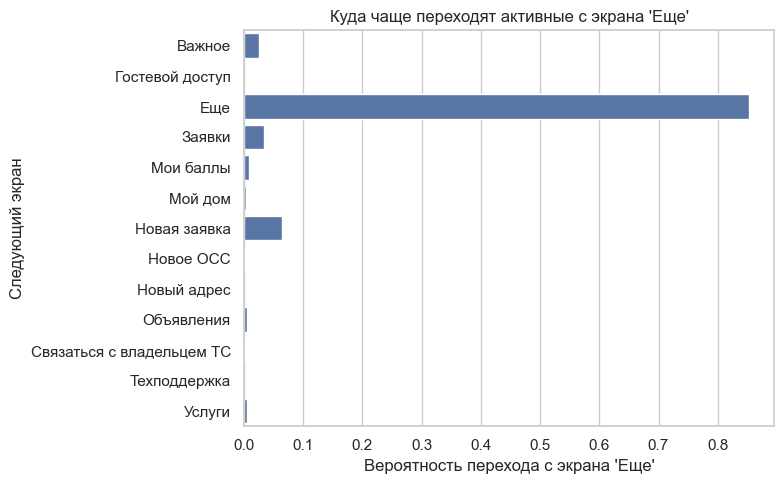

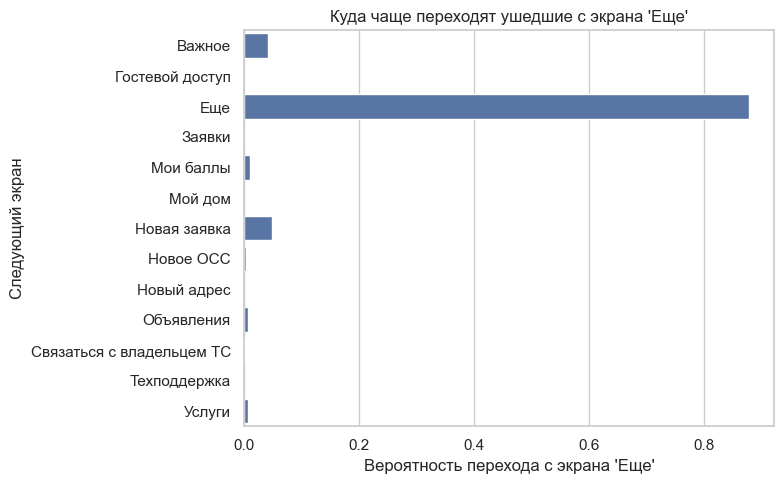

In [81]:
ej = transitions_churn_count[
    transitions_churn_count['prev_screen'] == 'Еще'
]

ej_active = (
    ej[ej['churn_30d'] == 0]
    .sort_values('prob', ascending=False)
    .head(10)
    .copy()
)

ej_churn = (
    ej[ej['churn_30d'] == 1]
    .sort_values('prob', ascending=False)
    .head(10)
    .copy()
)

def plot_from_main(df_top, title):
    plt.figure(figsize=(8, 5))
    # здесь y = 'Экран', category — seaborn с ним дружит
    sns.barplot(x='prob', y='Экран', data=df_top)
    plt.title(title)
    plt.xlabel("Вероятность перехода с экрана 'Еще'")
    plt.ylabel("Следующий экран")
    plt.tight_layout()
    plt.show()

plot_from_main(ej_active, "Куда чаще переходят активные с экрана 'Еще'")
plot_from_main(ej_churn,  "Куда чаще переходят ушедшие с экрана 'Еще'")


Пользовательский путь (customer journey) между ключевыми экранами приложения визуализирован с помощью диаграммы Санки. Эта диаграмма отображает основные переходы пользователей между экранами "Ещё", "Новая заявка", "Заявки", "Мой дом" и "Услуги".

Пользователи чаще всего переходят с экрана "Еще" на экран "Еще" (самый большой поток), что указывает на частое возвращение к главному меню. 

На диаграмме переходов ниже исключены самопереходы (например, “Ещё → Ещё”), чтобы лучше показать распределение переходов на другие экраны.

In [82]:
ej = transitions_churn_count[
    transitions_churn_count['prev_screen'] == 'Еще'
].copy()

# исключаем самопереходы "Еще → Еще"
ej = ej[ej['Экран'] != 'Еще'].copy()

# считаем нормализованную вероятность перехода
ej['prob_norm'] = ej.groupby('churn_30d')['count'].transform(lambda x: x / x.sum())

ej_active = (
    ej[ej['churn_30d'] == 0]
    .sort_values('prob_norm', ascending=False)
    .head(10)
)

ej_churn = (
    ej[ej['churn_30d'] == 1]
    .sort_values('prob_norm', ascending=False)
    .head(10)
)


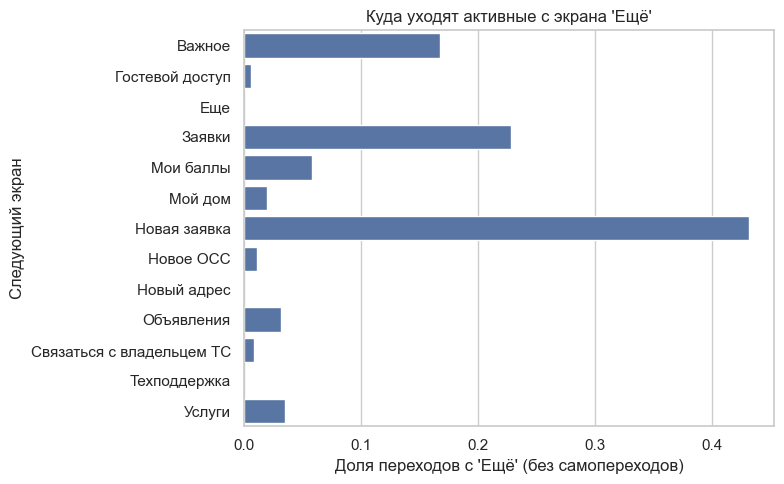

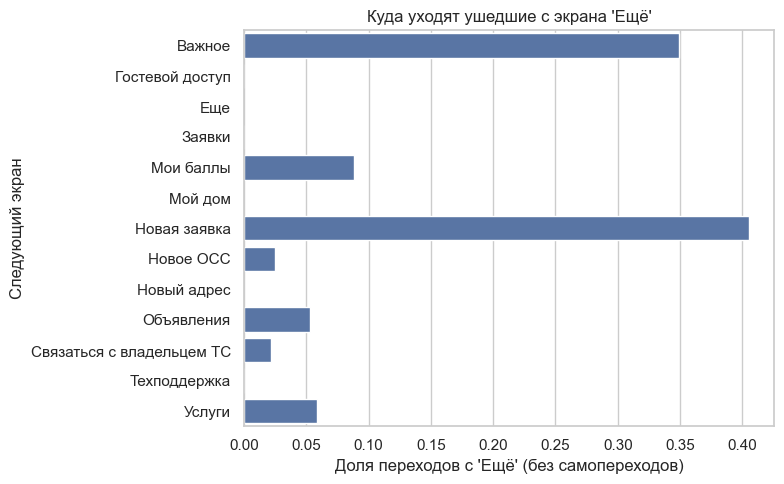

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_from_main(df_top, title):
    plt.figure(figsize=(8, 5))
    sns.barplot(x='prob_norm', y='Экран', data=df_top)
    plt.title(title)
    plt.xlabel("Доля переходов с 'Ещё' (без самопереходов)")
    plt.ylabel("Следующий экран")
    plt.tight_layout()
    plt.show()

plot_from_main(ej_active, "Куда уходят активные с экрана 'Ещё'")
plot_from_main(ej_churn,  "Куда уходят ушедшие с экрана 'Ещё'")


Гипотеза - ушедшие часто переходят на экран Важное и возможно ничего не находят там и уходят из приложения

У пользователей с оттоком доля действий “назад” чуть выше (4.9% против 4.0% у активных). Это может косвенно указывать на большее количество “блужданий” по экрану и сложности с навигацией, но разница невелика и требует дополнительной проверки.

In [85]:
import os

os.makedirs("data/processed", exist_ok=True)

processed_csv_path = "data/processed/events_clean.csv"
df.to_csv(processed_csv_path, index=False)
processed_csv_path


'data/processed/events_clean.csv'